This file will import Our World In Health Data from https://github.com/owid/covid-19-data/tree/master/public/data and clean it to remove NA values and include the relevant predictors needed. 


Documentation for what the variables mean: https://github.com/owid/covid-19-data/tree/master/public/data

**stringency\_index**: Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response).

**new\_cases\_smoothed** : New confirmed cases of COVID-19 (7-day smoothed). Counts can include probable cases, where reported.

**positive\_rate**: The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case).

**new\_vaccinations\_smoothed**: New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window

**weekly\_hosp\_admissions**: Number of COVID-19 patients newly admitted to hospitals in a given week (reporting date and the preceeding 6 days)

**weekly_icu_admissions** :Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week (reporting date and the preceeding 6 days)

**new_deaths_smoothed** : New deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported.


Note: confirmed cases and deaths are collected by Johns Hopkins University by date of report, rathen than date of test/death. Therefore the number they report on a given day does not necessarily represent the actual number on that date, because of the long reporting chain that exists between a new case/death and its inclusion in statistics. This also means that time series can show sudden changes (negative or positive) when a country corrects historical data, because it had previously under- or overestimated the number of cases/deaths.

### Tests & positivity
On 23 June 2022, we stopped adding new datapoints to our COVID-19 testing dataset. You can read more at https://github.com/owid/covid-19-data/discussions/2667.
| Variable                          | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
|:----------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_tests`                     | Total tests for COVID-19                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| `new_tests`                       | New tests for COVID-19 (only calculated for consecutive days)                                                                                                                                                                                                                                                                                                                                                                                                         |
| `total_tests_per_thousand`        | Total tests for COVID-19 per 1,000 people                                                                                                                                                                                                                                                                                                                                                                                                                             |
| `new_tests_per_thousand`          | New tests for COVID-19 per 1,000 people                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `new_tests_smoothed`              | New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window                                                                                                                                                  |
| `new_tests_smoothed_per_thousand` | New tests for COVID-19 (7-day smoothed) per 1,000 people                                                                                                                                                                                                                                                                                                                                                                                                              |
| `positive_rate`                   | The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)                                                                                                                                                                                                                                                                                                                                               |
| `tests_per_case`                  | Tests conducted per new confirmed case of COVID-19, given as a rolling 7-day average (this is the inverse of positive_rate)                                                                                                                                                                                                                                                                                                                                           |
| `tests_units`                     | Units used by the location to report its testing data. A country file can't contain mixed units. All metrics concerning testing data use the specified test unit. Valid units are 'people tested' (number of people tested), 'tests performed' (number of tests performed. a single person can be tested more than once in a given day) and 'samples tested' (number of samples tested. In some cases, more than one sample may be required to perform a given test.) |

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.utils import shuffle

In [31]:
df = pd.read_json('csv/owid-covid-data.json', orient='index') # Entire Dataset
df.head()

,continent,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,data,extreme_poverty,female_smokers,male_smokers
AFG,Asia,Afghanistan,40099462.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,37.746,0.50,64.83,0.511,"[{'date': '2020-02-24', 'total_cases': 5.0, 'n...",NaN,NaN,NaN
ALB,Europe,Albania,2854710.0,104.871,38.0,13.188,8.643,11803.431,304.195,10.08,NaN,2.89,78.57,0.795,"[{'date': '2020-02-25', 'total_tests': 8.0, 'n...",1.1,7.1,51.2
DZA,Africa,Algeria,44177969.0,17.348,29.1,6.211,3.857,13913.839,278.364,6.73,83.741,1.90,76.88,0.748,"[{'date': '2020-02-25', 'total_cases': 1.0, 'n...",0.5,0.7,30.4
AND,Europe,Andorra,79034.0,163.755,NaN,NaN,NaN,NaN,109.135,7.97,NaN,NaN,83.73,0.868,"[{'date': '2020-03-02', 'total_cases': 1.0, 'n...",NaN,29.0,37.8
AGO,Africa,Angola,34503774.0,23.890,16.8,2.405,1.362,5819.495,276.045,3.94,26.664,NaN,61.15,0.581,"[{'date': '2020-03-20', 'total_cases': 1.0, 'n...",NaN,NaN,NaN


In [32]:
countries = ['Canada', 'United States', 'Australia', 'United Kingdom', 'New Zealand']
# Create a hierarchical structure. 
country_dic = {country:pd.DataFrame(df[df.location == country]['data'].item()) for country in countries}
health_df = pd.concat(country_dic, axis=0)

In [33]:
health_df = health_df[['date', 'stringency_index','positive_rate', 'new_cases_smoothed', 'new_deaths_smoothed', 
        'weekly_hosp_admissions','new_vaccinations_smoothed', 'new_people_vaccinated_smoothed','new_cases']]

<AxesSubplot:>

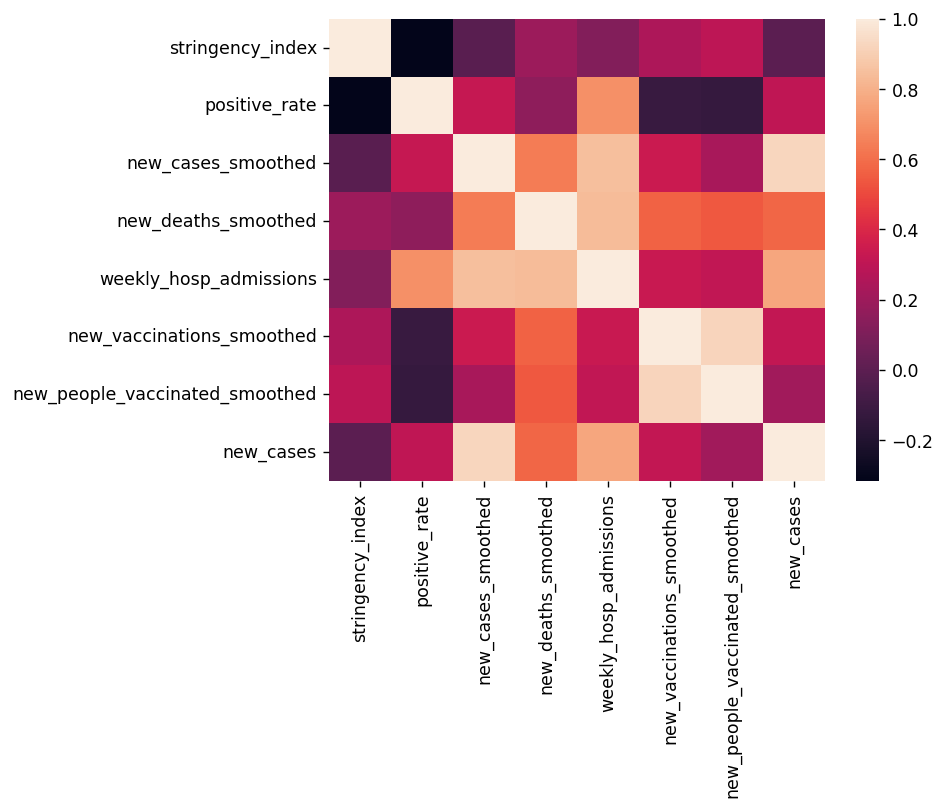

In [34]:
plt.figure(dpi=125)
sns.heatmap(health_df.corr())

In [35]:
health_df.corr()

,stringency_index,positive_rate,new_cases_smoothed,new_deaths_smoothed,weekly_hosp_admissions,new_vaccinations_smoothed,new_people_vaccinated_smoothed,new_cases
stringency_index,1.000000,-0.316701,-0.011687,0.193094,0.119018,0.246531,0.299232,-0.006461
positive_rate,-0.316701,1.000000,0.321409,0.151970,0.697110,-0.116439,-0.131462,0.303508
new_cases_smoothed,-0.011687,0.321409,1.000000,0.638728,0.848242,0.337381,0.228581,0.924604
new_deaths_smoothed,0.193094,0.151970,0.638728,1.000000,0.840155,0.565165,0.538377,0.574028
weekly_hosp_admissions,0.119018,0.697110,0.848242,0.840155,1.000000,0.332747,0.308016,0.764379
new_vaccinations_smoothed,0.246531,-0.116439,0.337381,0.565165,0.332747,1.000000,0.921418,0.314543
new_people_vaccinated_smoothed,0.299232,-0.131462,0.228581,0.538377,0.308016,0.921418,1.000000,0.208706
new_cases,-0.006461,0.303508,0.924604,0.574028,0.764379,0.314543,0.208706,1.000000


In [36]:
health_df.date = pd.to_datetime(health_df.date)
health_df.to_parquet('parquet/cleaned_health_data.parquet')